In [1]:
import json
from glob import glob
import os
import re

import pygsheets
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Get data from gsheets

In [2]:
#authorization
gc = pygsheets.authorize(service_file="./secrets/gdocs_service.json")

In [3]:
noodle_sheet = gc.open("🐍 Noodle stats 🐍")

In [4]:
feeding_sheet = noodle_sheet.worksheet_by_title("feeding")
weight_sheet = noodle_sheet.worksheet_by_title("weight")
shedding_sheet = noodle_sheet.worksheet_by_title("shedding")

In [5]:
feeding_df = feeding_sheet.get_as_df()
weight_df = weight_sheet.get_as_df()
shedding_df = shedding_sheet.get_as_df()

# Preprocessing

In [6]:
weight_df["date"] = pd.to_datetime(weight_df["date"])
feeding_df["date"] = pd.to_datetime(feeding_df["date"])
shedding_df["date"] = pd.to_datetime(shedding_df["date"])
feeding_df["accepted"] = feeding_df["accepted"] == "yes"
feeding_df["food weight [g]"] = feeding_df["food weight [g]"].astype(float)

In [7]:
weight_df.head()

,date,weight [g]
0,2021-03-19,11.00
1,2021-03-23,12.71
2,2021-03-24,12.25
3,2021-03-28,13.40
4,2021-03-29,12.29


In [8]:
feeding_df.head()

,date,accepted,food,method,food weight [g],comments
0,2021-03-17,True,f/t pinkie brained,tongs in viv,1.50,"left in viv for a few hours, then opportunisti..."
1,2021-03-21,True,f/t pinkie brained,tongs in viv,1.50,"left in exo terra for ~3h, then in fridge unti..."
2,2021-03-26,True,f/t pinkie,tongs in viv,1.50,"dumped 🐍 out of hide, booped nose a few times...."
3,2021-03-30,True,f/t pinkie,tongs in viv,1.80,"🐍 was out, booped nose, accepted immediately"
4,2021-04-03,True,f/t pinkie,tongs in viv,1.65,"booped nose, immediate strike"


In [9]:
shedding_df.head()

,date,shed_idx,comment
0,2021-03-17,1,"head stuck, rest 1 big piece + small bit"
1,2021-07-03,2,First noticed blue/cloudy eyes
2,2021-07-08,2,eyes completely clear (red) again
3,2021-09-09,3,First noticed blue/cloudy eyes
4,2021-09-14,3,Found shed


In [10]:
shed_ranges = shedding_df.groupby("shed_idx")["date"].agg(["min", "max"])

In [11]:
# start + end time of each shed and a nan y value in between to break the line
shed_plot_xs = sum(([r.min, r.max, r.max + pd.Timedelta(hours=1)] for r in shed_ranges.itertuples()), start=[])
shed_plot_ys = np.array(sum(([1, 1, np.nan] for _ in range(len(shed_ranges))), start=[]))

# Export data

In [12]:
images = [
    {"fname": (fname := os.path.split(p)[1]),
     "date": pd.to_datetime(re.search("\d{8}", fname).group()).strftime("%Y-%m-%d")}
      for p in glob("./web/data/images/*")
]
images.sort(key=lambda x: x["date"])

In [13]:
data = {
    "shedding": [[r.min.strftime("%Y-%m-%d"), r.max.strftime("%Y-%m-%d")] for r in shed_ranges.itertuples()],
    "feeding_accepted": {
        "date": feeding_df.query("accepted")["date"].dt.strftime("%Y-%m-%d").to_list(),
        "food_weight": feeding_df.query("accepted")["food weight [g]"].to_list(),
    },
    "feeding_rejected": {
        "date": feeding_df.query("~accepted")["date"].dt.strftime("%Y-%m-%d").to_list(),
        "food_weight": feeding_df.query("~accepted")["food weight [g]"].to_list(),
    },
    "weight": {
        "date": weight_df["date"].dt.strftime("%Y-%m-%d").to_list(),
        "weight": weight_df["weight [g]"].to_list(),
    },
    "images": images
}

with open("web/data/noodle_data.json", "w") as f:
    json.dump(data, f)

Create thumbnails

In [14]:
!magick mogrify -path web/data/thumbnails -thumbnail 200x200 web/data/images/*

# Plotting

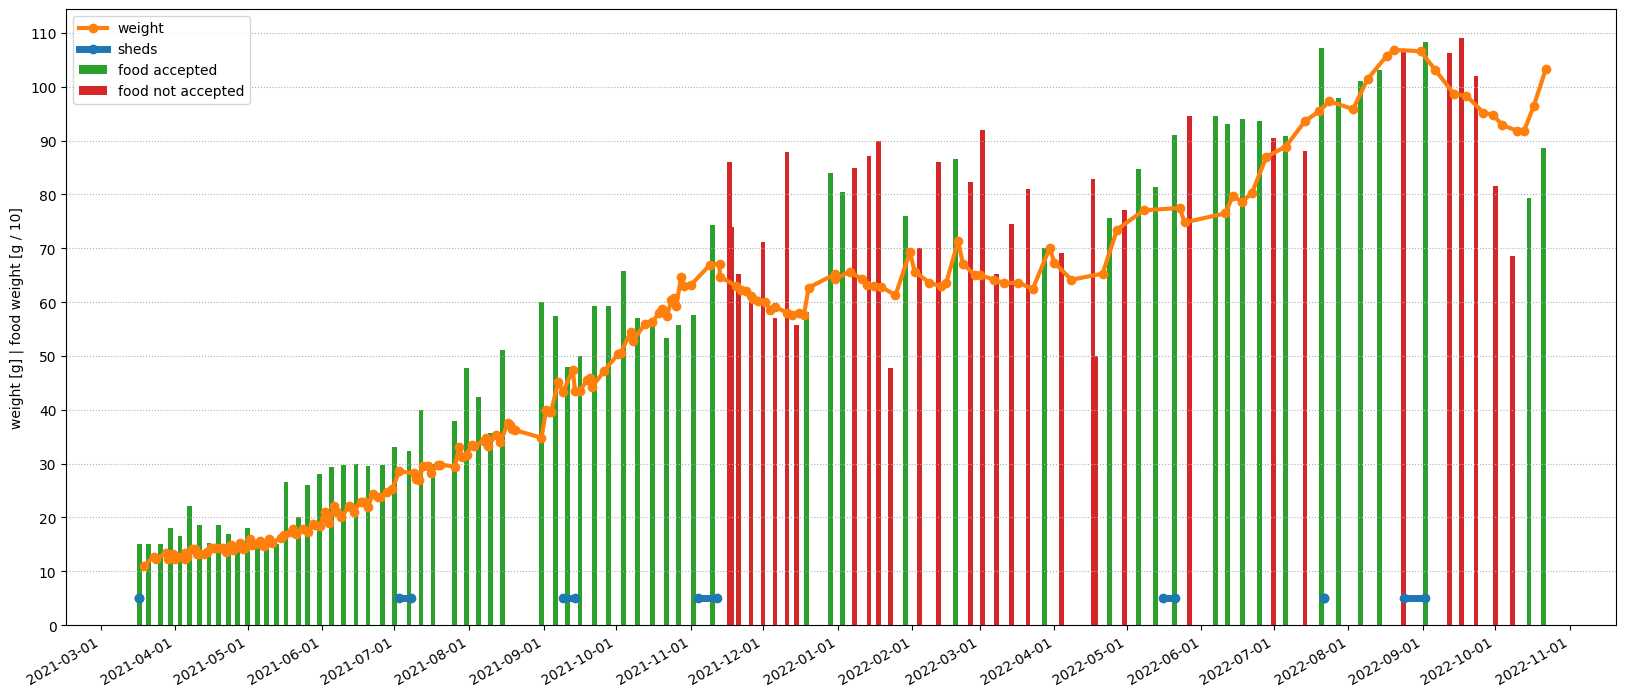

In [15]:
blue, orange, green, red, *_ = sns.color_palette()

fig, ax = plt.subplots(1, figsize=(20, 8))
plt.plot(weight_df["date"], weight_df["weight [g]"], marker="o", linewidth=3, color=orange)


f_accept = feeding_df.query("accepted")
f_noaccept = feeding_df.query("~accepted")
plt.bar(f_accept["date"], f_accept["food weight [g]"] * 10, color=green, width=2)
plt.bar(f_noaccept["date"], f_noaccept["food weight [g]"] * 10, color=red, width=2)


plt.xticks(rotation=30, ha="right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid(True, axis="y", linestyle=":")
plt.ylabel("weight [g] | food weight [g / 10]")
plt.xticks(pd.date_range(weight_df["date"].min() - pd.Timedelta(weeks=4), weight_df["date"].max() + pd.Timedelta(weeks=4), freq="MS"))

plt.plot(shed_plot_xs, shed_plot_ys * 5, linewidth=5, marker="o")


plt.legend(["weight", "sheds", "food accepted", "food not accepted"])

plt.savefig("output/noodle_graph.svg")

matplotlib.rcParams['figure.dpi'] = 300
plt.savefig("output/noodle_graph.png", bbox_inches="tight")